### CODE FOR FORECASTING CSS MASTERS INTRO

The code here uses LJ electricity prices for examining basic techniques in forecasting.

We construct pictures for the lecture notes

In [1]:
# load data and packages

import numpy as np
import pandas as pd
import datetime
from pandas import Series, DataFrame
import statsmodels.api as sm
import matplotlib.pyplot as plt



bd = pd.read_csv('CSS_Energy.csv', sep=",")
# Data is daily average LMP at the La Jolla hub and the daily Henry Hub gas prices. 
# Henry Hub gas prices are Friday prices for the weekend (the market is closed on weekends)

# construct index
bd['Datetime'] =pd.to_datetime(bd.Datetime)
bd = bd.set_index('Datetime')

In [2]:
bd.head()

,LMP,HenryHub
Datetime,,
2012-01-01,27.410687,2.98
2012-01-02,27.860928,2.98
2012-01-03,27.417081,2.97
2012-01-04,26.372413,2.96
2012-01-05,26.780845,2.91


In [3]:
bd.tail()

,LMP,HenryHub
Datetime,,
2020-12-27,39.039725,2.68
2020-12-28,43.011804,2.39
2020-12-29,41.501950,2.40
2020-12-30,40.447958,2.36
2020-12-31,35.281958,2.36


### First Look at the data

We will be forecasting observations in January 2020 using earlier data. 


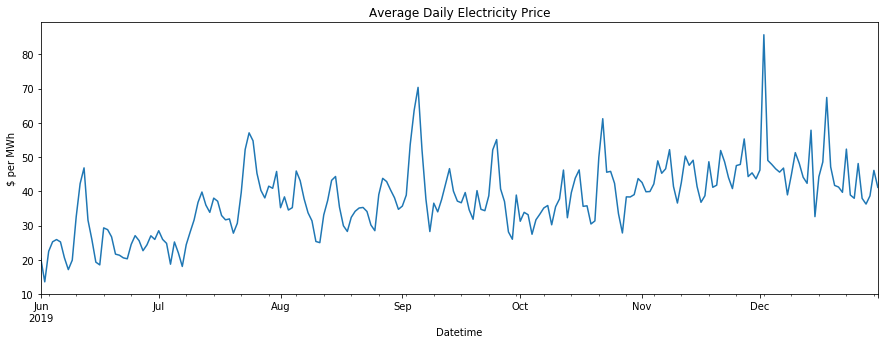

In [4]:
# graph data near the forecast point

fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data
bd.LMP.loc['2019-06-01':'2019-12-31'].plot(ax=ax)
plt.title('Average Daily Electricity Price')
plt.ylabel('$ per MWh')

plt.show()

Suppose now we want to forecast into 2020.

We now have to make all the choices I have been talking about in the lecture.

What is the relevant loss function? We like most will choose Mean Square Error. This is not neccessarily appropriate in all cases.

What is the set of models we are willing to consider? Here we do simple things, but they work pretty well (what does that mean?)

What estimation strategies should we employ once we choose a model? 

In [7]:
# Start with an autoregressive model. I have chosen 7 lags, why?

# Because we might have weekly effects, Sundays are like Sundays etc.

# Construct the model
mod = sm.tsa.SARIMAX(bd.LMP['2019'], order=(7, 0, 0), trend='c', freq="D")
# Estimate the parameters
res = mod.fit()

print(res.summary())

D:\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                    LMP   No. Observations:                  365
Model:               SARIMAX(7, 0, 0)   Log Likelihood               -1346.063
Date:                Thu, 01 Sep 2022   AIC                           2710.125
Time:                        16:07:18   BIC                           2745.224
Sample:                    01-01-2019   HQIC                          2724.074
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.0811      1.498      2.723      0.006       1.144       7.018
ar.L1          0.7628      0.032     23.610      0.000       0.699       0.826
ar.L2         -0.0491      0.056     -0.873      0.3

We are probably used to looking at t stats, using the magical 2 as the criterion. 

The first lag and the seventh lag are doing most of the heavy lifting here, the other coefficients are close to zero. 

Why can I just compare the sizes of the coefficients?

In [8]:
fcast_res = res.get_forecast(steps=15)
# Note: since we did not specify the alpha parameter, the
# confidence level is at the default, 95%
print(fcast_res.summary_frame())

LMP              mean    mean_se  mean_ci_lower  mean_ci_upper
2020-01-01  40.035609   9.648851      21.124209      58.947009
2020-01-02  42.356967  12.135406      18.572008      66.141926
2020-01-03  41.380904  13.179093      15.550357      67.211451
2020-01-04  39.955063  13.931702      12.649430      67.260697
2020-01-05  39.631472  14.368332      11.470058      67.792885
2020-01-06  40.867094  14.551022      12.347614      69.386574
2020-01-07  40.718669  14.606019      12.091397      69.345941
2020-01-08  40.329041  14.812492      11.297091      69.360992
2020-01-09  40.701571  15.112658      11.081305      70.321837
2020-01-10  40.802562  15.392592      10.633635      70.971488
2020-01-11  40.518269  15.673767       9.798250      71.238287
2020-01-12  40.258672  15.933828       9.028943      71.488401
2020-01-13  40.324722  16.131674       8.707222      71.942223
2020-01-14  40.323921  16.256697       8.461381      72.186461
2020-01-15  40.217328  16.361703       8.148979      72

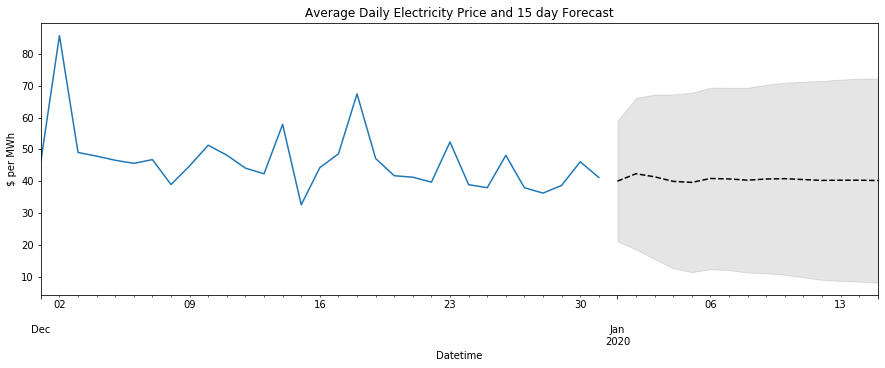

In [10]:
# It is easier to look at this in a picture

fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
bd.LMP.loc['2019-12-01':'2019-12-31'].plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast('2020-01-15').summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);
plt.title('Average Daily Electricity Price and 15 day Forecast')
plt.ylabel('$ per MWh')

plt.show()

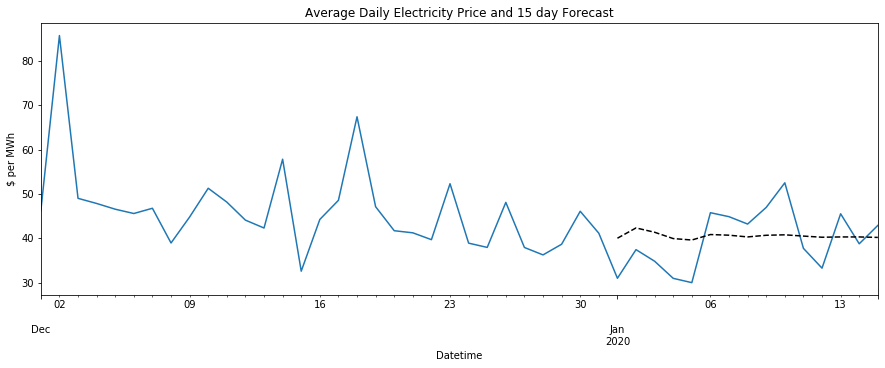

In [12]:
# Get rid of the so called confidence bands

fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
bd.LMP.loc['2019-12-01':'2020-01-15'].plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast('2020-01-15').summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
plt.title('Average Daily Electricity Price and 15 day Forecast')
plt.ylabel('$ per MWh')

plt.show()

Things to note:
    
    1. The forecast is quite flat. This is a general truth in time series forecasting when the variable to be forecast does 
    not vary much.
    
    2. A 'random walk' forecast would do just as well. This often leads people to think that these types of series actually have
    random walks, which is silly.
    
    3. Using only the past values does actually provide a reasonable forecast in many situations, depending on the meaning 
    of the word reasonable. 
    
    4. There are other models to consider with just a univariate series. 

In [13]:
# How about a seventh order moving average model


# Construct the model
mod = sm.tsa.SARIMAX(bd.LMP['2019'], order=(0, 0, 7), trend='c', freq="D")
# Estimate the parameters
resma = mod.fit()

print(resma.summary())

D:\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                    LMP   No. Observations:                  365
Model:               SARIMAX(0, 0, 7)   Log Likelihood               -1362.231
Date:                Thu, 01 Sep 2022   AIC                           2742.461
Time:                        16:25:52   BIC                           2777.560
Sample:                    01-01-2019   HQIC                          2756.410
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     39.4413      2.750     14.340      0.000      34.051      44.832
ma.L1          0.8393      0.033     25.627      0.000       0.775       0.904
ma.L2          0.6685      0.047     14.258      0.0

In [15]:
fcast_resma = resma.get_forecast(steps=15)
print(fcast_resma.summary_frame())

LMP              mean    mean_se  mean_ci_lower  mean_ci_upper
2020-01-01  40.847213  10.090300      21.070589      60.623838
2020-01-02  42.454918  13.173337      16.635652      68.274184
2020-01-03  40.488435  14.799895      11.481173      69.495697
2020-01-04  39.816363  15.961508       8.532383      71.100343
2020-01-05  39.245671  16.578156       6.753083      71.738258
2020-01-06  39.719398  16.731071       6.927101      72.511696
2020-01-07  39.291976  16.736080       6.489863      72.094090
2020-01-08  39.441312  16.748262       6.615322      72.267302
2020-01-09  39.441312  16.748262       6.615322      72.267302
2020-01-10  39.441312  16.748262       6.615322      72.267302
2020-01-11  39.441312  16.748262       6.615322      72.267302
2020-01-12  39.441312  16.748262       6.615322      72.267302
2020-01-13  39.441312  16.748262       6.615322      72.267302
2020-01-14  39.441312  16.748262       6.615322      72.267302
2020-01-15  39.441312  16.748262       6.615322      72

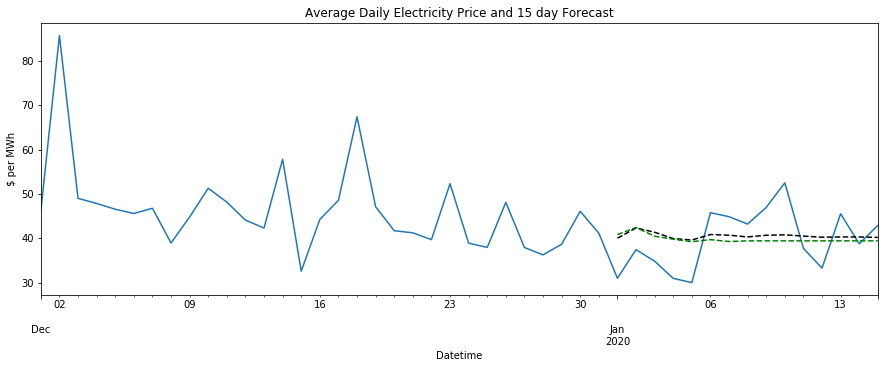

In [17]:
# Plot our new forecasts along with the old ones

fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
bd.LMP.loc['2019-12-01':'2020-01-15'].plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast('2020-01-15').summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
fcastma = resma.get_forecast('2020-01-15').summary_frame()
fcastma['mean'].plot(ax=ax, style='g--')
plt.title('Average Daily Electricity Price and 15 day Forecast')
plt.ylabel('$ per MWh')

plt.show()

In [18]:
# We saw in the autoregressive model that it was really the first and seventh coefficients. So perhaps hone in a bit. 

# Construct the model with daily 'seasonal'
mod = sm.tsa.SARIMAX(bd.LMP['2019'], order=(1, 0, 0), trend='c',seasonal_order=(1,0,1,7),freq="D")

# Estimate the parameters
ress = mod.fit()

print(ress.summary())

D:\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                      SARIMAX Results                                      
Dep. Variable:                                 LMP   No. Observations:                  365
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -1332.906
Date:                             Thu, 01 Sep 2022   AIC                           2675.811
Time:                                     16:29:36   BIC                           2695.311
Sample:                                 01-01-2019   HQIC                          2683.561
                                      - 12-31-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0443      0.073      0.606      0.545      -0.099       0.188
ar.L1          0.8416      

D:\Python\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


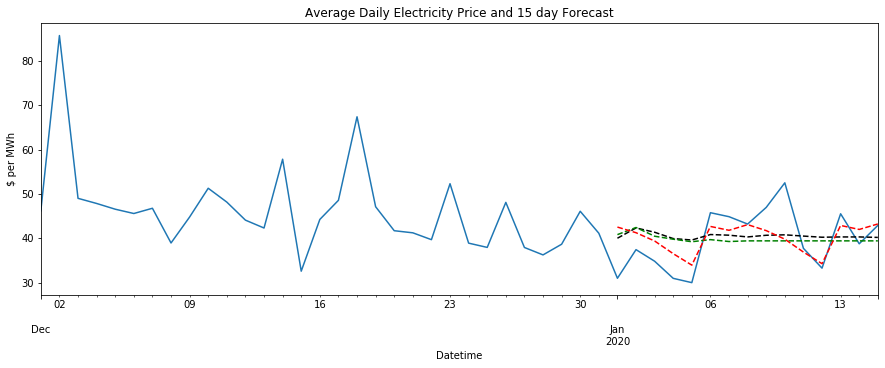

In [20]:
# lets look at a picture of our three approaches

fcast_ress = ress.get_forecast(steps=15)
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
bd.LMP.loc['2019-12-01':'2020-01-15'].plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast('2020-01-15').summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
fcastma = resma.get_forecast('2020-01-15').summary_frame()
fcastma['mean'].plot(ax=ax, style='g--')
fcastars = ress.get_forecast('2020-01-15').summary_frame()
fcastars['mean'].plot(ax=ax, style='r--')
plt.title('Average Daily Electricity Price and 15 day Forecast')
plt.ylabel('$ per MWh')

plt.show()

So in this case we are capturing more of the variation.

All of this is fine, but perhaps we should look at the average loss.

The problem with this is that we have only 15 observations to estimate the loss

In [39]:
act = bd.LMP.loc['2020-01-01':'2020-01-15']   # the values we wanted to predict
ferar = act - fcast['mean']                           # forecast errors from the AR model.
fersar = act - fcastars['mean']                       # forecast errors from the seasonal model.

# construct our loss measures
ferar2 = ferar*ferar
fersar2 = fersar*fersar

mse_ar = np.mean(ferar2)
mse_sar = np.mean(fersar2)

print('MSE loss estimate for AR model' , round(mse_ar,2))
print('MSE loss estimate for SAR model', round(mse_sar,2))

MSE loss estimate for AR model 42.78
MSE loss estimate for SAR model 29.51


In general we can compare the means, but they are estimates. And estimates of means should be compared related to their
precision in estimation. 

We need standard errors!

In [44]:
msestd_ar = np.std(ferar2)/15
msestd_sar = np.std(fersar2)/15

print('MSE loss estimate for AR model s.e.' , round(msestd_ar,2))
print('MSE loss estimate for SAR model s.e.', round(msestd_sar,2))

MSE loss estimate for AR model s.e. 2.51
MSE loss estimate for SAR model s.e. 3.16


So which is really better? How confident are you?

In practice we might look at a lot more 'sets' of forecasts. This would help, but complicates the comparison. 



In [42]:
print([ferar , fersar])

[Datetime
2020-01-01    -9.031930
2020-01-02    -4.895651
2020-01-03    -6.533616
2020-01-04    -8.969330
2020-01-05    -9.615838
2020-01-06     4.924160
2020-01-07     4.173339
2020-01-08     2.903359
2020-01-09     6.285204
2020-01-10    11.732201
2020-01-11    -2.764785
2020-01-12    -6.974322
2020-01-13     5.222790
2020-01-14    -1.542659
2020-01-15     2.706397
dtype: float64, Datetime
2020-01-01   -11.547978
2020-01-02    -3.817219
2020-01-03    -4.565990
2020-01-04    -5.563832
2020-01-05    -3.946999
2020-01-06     3.099052
2020-01-07     3.067675
2020-01-08     0.129385
2020-01-09     5.237745
2020-01-10    12.713555
2020-01-11     0.839695
2020-01-12    -1.006946
2020-01-13     2.631992
2020-01-14    -3.234534
2020-01-15    -0.330052
dtype: float64]
